# pyiron

## Define workflow with pyiron_base

In [1]:
import numpy as np
from pyiron_base import job
from python_workflow_definition.pyiron_base import write_workflow_json

In [2]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [3]:
workflow_json_filename = "pyiron_base_qe.json"

In [4]:
calculate_qe = job(_calculate_qe, output_key_lst=["energy", "volume", "structure"])
generate_structures = job(_generate_structures)
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [5]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [6]:
structure = get_bulk_structure(
    element="Al",
    a=4.04,
    cubic=True,
)

In [7]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [8]:
number_of_strains = 5
structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
    list_length=number_of_strains,
)

In [9]:
job_strain_lst = []
for i, structure_strain in enumerate(structure_lst):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": structure_strain,
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [10]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [11]:
write_workflow_json(delayed_object=plot, file_name=workflow_json_filename)

In [12]:
!cat {workflow_json_filename}

{
  "version": "0.1.0",
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.plot_energy_volume_curve"
    },
    {
      "id": 1,
      "type": "function",
      "value": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 3,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 4,
      "type": "function",
      "value": "workflow.generate_structures"
    },
    {
      "id": 5,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 6,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "type": "function",
      "value": "workflow.get_bulk_structure"
    },
    {
      "id": 8,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 9,
      "type": "fu

## Load Workflow with aiida

In [13]:
from aiida import orm, load_profile

load_profile()

Profile<uuid='1682a1dbda304ec998030372ef5350ab' name='pwd'>

In [14]:
from python_workflow_definition.aiida import load_workflow_json

In [15]:
wg = load_workflow_json(file_name=workflow_json_filename)

In [16]:
wg.nodes.get_bulk_structure8.inputs.a.value = orm.Float(4.05)

05/26/2025 04:46:41 AM <1688> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure8
05/26/2025 04:46:41 AM <1688> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|update_task_state]: Task: get_bulk_structure8, type: PyFunction, finished.
05/26/2025 04:46:41 AM <1688> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict7
05/26/2025 04:46:42 AM <1688> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|update_task_state]: Task: get_dict7, type: PyFunction, finished.
05/26/2025 04:46:42 AM <1688> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe6
[jupyter-pythonworkflow-fl--x---218119f8:01776] mca_base_component_repository_open: unable to open mca_btl_o

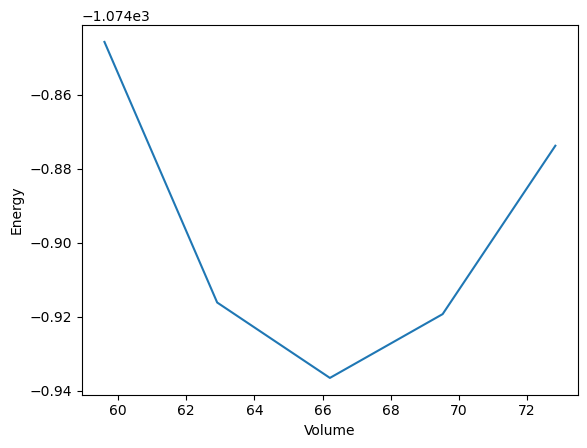

In [17]:
wg.run()

## Load Workflow with jobflow

In [18]:
from python_workflow_definition.jobflow import load_workflow_json

In [19]:
from jobflow.managers.local import run_locally

In [20]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [21]:
flow[0].function_kwargs["a"] = 4.05

2025-05-26 04:48:47,564 INFO Started executing jobs locally
2025-05-26 04:48:47,751 INFO Starting job - get_bulk_structure (f386f375-fcc9-4700-a077-b8c7b4ed29d4)
2025-05-26 04:48:47,754 INFO Finished job - get_bulk_structure (f386f375-fcc9-4700-a077-b8c7b4ed29d4)
2025-05-26 04:48:47,755 INFO Starting job - get_dict (6c1c9b0f-5c14-4ae9-be98-984400228394)
2025-05-26 04:48:47,757 INFO Finished job - get_dict (6c1c9b0f-5c14-4ae9-be98-984400228394)
2025-05-26 04:48:47,757 INFO Starting job - calculate_qe (f511b680-fa97-420f-904d-2ae232dbe75b)


[jupyter-pythonworkflow-fl--x---218119f8:01905] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-26 04:49:37,980 INFO Finished job - calculate_qe (f511b680-fa97-420f-904d-2ae232dbe75b)
2025-05-26 04:49:37,981 INFO Starting job - generate_structures (d5fc7015-e7fe-4111-bf16-23bdc6755f93)
2025-05-26 04:49:37,985 INFO Finished job - generate_structures (d5fc7015-e7fe-4111-bf16-23bdc6755f93)
2025-05-26 04:49:37,986 INFO Starting job - get_dict (49b7b2e8-78ca-4d63-bfa6-f3b47ca3378f)
2025-05-26 04:49:37,988 INFO Finished job - get_dict (49b7b2e8-78ca-4d63-bfa6-f3b47ca3378f)
2025-05-26 04:49:37,988 INFO Starting job - get_dict (a45e0be5-c229-4817-8dc8-e2f54c46205f)
2025-05-26 04:49:37,990 INFO Finished job - get_dict (a45e0be5-c229-4817-8dc8-e2f54c46205f)
2025-05-26 04:49:37,990 INFO Starting job - get_dict (30bf90f1-57c2-474b-8bd2-d8a18061d85c)
2025-05-26 04:49:37,992 INFO Finished job - get_dict (30bf90f1-57c2-474b-8bd2-d8a18061d85c)
2025-05-26 04:49:37,993 INFO Starting job - get_dict (d4b595f2-93a9-42d7-a547-f64be9b4ca80)
2025-05-26 04:49:37,995 INFO Finished job - get_dict (

[jupyter-pythonworkflow-fl--x---218119f8:01923] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:49:48,629 INFO Finished job - calculate_qe (e747fb6a-e704-44ff-906e-664be75da6fc)
2025-05-26 04:49:48,630 INFO Starting job - calculate_qe (579fbf80-e6e7-464c-a808-f5cecd9ef430)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:01934] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:50:00,439 INFO Finished job - calculate_qe (579fbf80-e6e7-464c-a808-f5cecd9ef430)
2025-05-26 04:50:00,439 INFO Starting job - calculate_qe (ceb70e3f-c90a-4aa3-a670-23ecf40fa11b)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:01945] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:50:13,181 INFO Finished job - calculate_qe (ceb70e3f-c90a-4aa3-a670-23ecf40fa11b)
2025-05-26 04:50:13,182 INFO Starting job - calculate_qe (290a2a1d-9a74-40b1-af28-e4f61b357694)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:01955] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:50:27,249 INFO Finished job - calculate_qe (290a2a1d-9a74-40b1-af28-e4f61b357694)
2025-05-26 04:50:27,250 INFO Starting job - calculate_qe (a9f810e8-c291-46b9-ab8f-4c59765bf3b9)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:01965] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:50:37,525 INFO Finished job - calculate_qe (a9f810e8-c291-46b9-ab8f-4c59765bf3b9)
2025-05-26 04:50:37,526 INFO Starting job - get_list (20122c29-0e2d-4a9c-8506-d371390f8042)
2025-05-26 04:50:37,528 INFO Finished job - get_list (20122c29-0e2d-4a9c-8506-d371390f8042)
2025-05-26 04:50:37,529 INFO Starting job - get_list (9842e2f0-3ca3-4a23-b82b-a3644a0294a8)
2025-05-26 04:50:37,531 INFO Finished job - get_list (9842e2f0-3ca3-4a23-b82b-a3644a0294a8)
2025-05-26 04:50:37,532 INFO Starting job - plot_energy_volume_curve (a1614162-0427-4cd2-a2c4-01837c5ae505)
2025-05-26 04:50:37,581 INFO Finished job - plot_energy_volume_curve (a1614162-0427-4cd2-a2c4-01837c5ae505)
2025-05-26 04:50:37,582 INFO Finished executing jobs locally


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


{'f386f375-fcc9-4700-a077-b8c7b4ed29d4': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

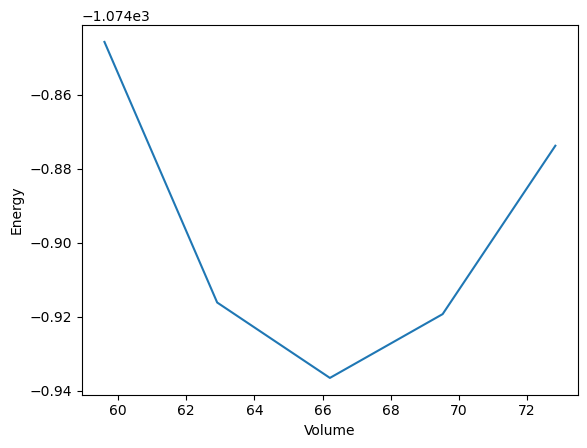

In [22]:
result = run_locally(flow)
result

## Load Workflow with pyiron_workflow

In [23]:
from python_workflow_definition.pyiron_workflow import load_workflow_json

In [24]:
wf = load_workflow_json(file_name=workflow_json_filename)

In [25]:
wf.get_bulk_structure.inputs.a.value = 4.05

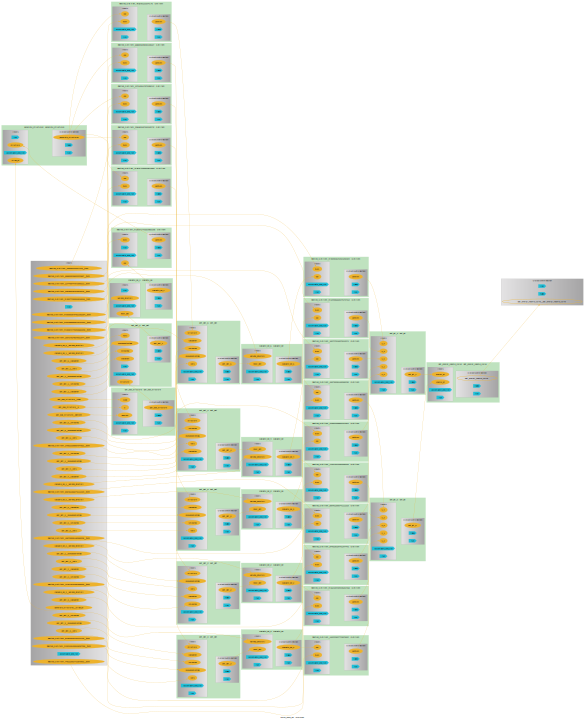

In [26]:
wf.draw(size=(10,10))

[jupyter-pythonworkflow-fl--x---218119f8:01978] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:01993] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02008] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02018] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: 

{'plot_energy_volume_curve__plot_energy_volume_curve': None}

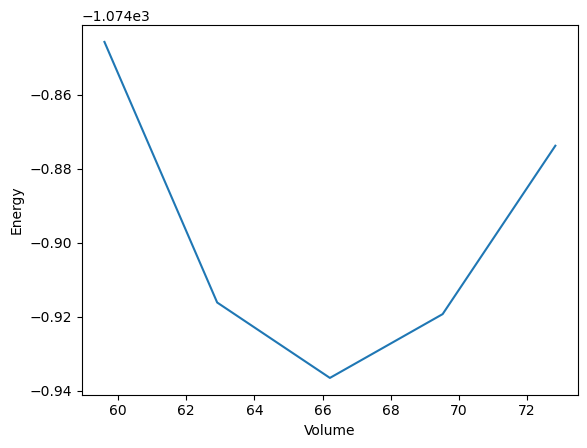

In [27]:
wf.run()